# Inferring Velocities By Modelling the Line as a Gaussian Process

This Notebook builds upon the previous [Notebook](fitannulus_1.ipynb) and demonstrates the improves made in the technique as described in Teague et al. (2018b). To be able to play with this you need to have installed the [`celerite`](http://celerite.readthedocs.io/en/stable/) 1-D Gaussian Process package and [`emcee`](http://dfm.io/emcee/current/) for running the MCMC.

## Methodology

The intial method aimed to minimize the width of a stacked spectrum. However, this makes the implicit assumption that the resulting line profile is Gaussian in shape. It also fails to return a good measure of the uncertainty of this result and assumed that all the points used in fitting were independent. We can do a better job by using a Gaussian Process to model the resulting stacked spectra. [Czekala et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...840...49C) provide a lot more detail about modelling spectra as Gaussian Processes which I thoroughly recommend reading.

In brief, a Gaussian Process is a way to model a smoothly varying (for some defined level of 'smoothness') function in a non-parametric way. This makes it perfect for modelling many things in astronomy which we know are not quite a an analytical function, but also too structured to include a lot of additional terms. For more information check out the N-D Gaussian Process code [`george`](http://dfm.io/george/current/) which gives a thorough demonstration of what one can do with these.

Thus, when used in our modelling, rather than searching for the stacked spectrum which has the narrowest width, we search for the one which has the smoothest model (equally, reduces the variance of the residuals). This probabilistic approach naturally spits out an uncertainty and (rather nicely) accounts for covariances between data points.

---

![Scatter in the residuals.](../_static/deprojection_example.png)


In the example above, taken from Teague et al. (2018b), the left panel shows the case where the assumed $v_{\rm rot}$ was incorrect resulting in a large variance in the residuals between the shifted data (gray points) and the Gaussian Process model (blue line). Conversely, when the correct $v_{\rm rot}$ is used for the deprojection, as in the right panel, the residuals are much more constant across the spectrum.

---

## Application

This method uses the same principle as discussed in the previous notebook: an annulus of spectra with known azimuthal angles, $\theta$, are shifted to a common systemic velocity, $v_{\rm LSR}$. As in the previous Notebook we start with an annulus of points.

In [1]:
%matplotlib inline
import numpy as np
from eddy.modelling import gaussian_ensemble
from eddy.fit_annulus import annulus
np.random.seed(42)

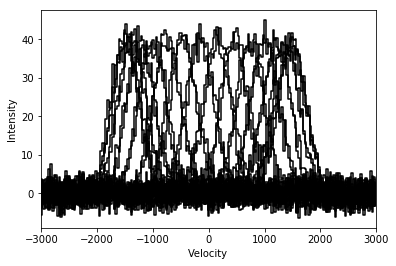

In [2]:
ensemble = gaussian_ensemble(vrot=1500., Tb=40., dV=350., rms=2.0, N=30, plot=True, return_annulus=True)

To use the Gaussian Process method we use the `get_vrot_GP()` function. Again this takes as an argument an initial guess to concentrate the search. Additionally it takes parameters to modify the MCMC runs.

The modelling of the line will first deproject all the spectra with a given `vrot` value. Then, using the parameters which describe the Gaussian Process model (the noise, the correlation length and correlation strength, all of which we marginalize over at the end) are used to build a Gaussian Process model of the data. We use the inbuild `celerite.log_likelihood()` function to calculate the likelihood which takes into account the full covariance matrix.

By default this function will not plot the sampling and the corner plot but they can be useful to understand what's going on. What's returned are the 16th, 50th and 84th percentile of the `vrot` posterior distribution. Using `return_all=True` you can get the same percentiles for all the parameters, for example if you wanted an estimate of the noise.

In [14]:
vfit = ensemble.get_vlos(fit_method='dV', resample=False)
print(vfit)

[1494.74045197]


In [10]:
vfit = ensemble.get_vlos(fit_method='SNR', signal='int', resample=True)
print(vfit)
vfit = ensemble.get_vlos(fit_method='SNR', signal='weighted', resample=True)
print(vfit)
vfit = ensemble.get_vlos(fit_method='SNR', signal='max', resample=True)
print(vfit)

[1494.74043747]
[1494.74043747]
[1494.74043747]


100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


[array([[1507.51220289, 1509.25122618, 1509.81337257],
       [   1.98479308,    2.01183804,    2.02867407],
       [   1.91663659,    2.02705835,    2.12556888],
       [   6.2860717 ,    6.53601503,    6.76754871]])]


IndexError: list index out of range

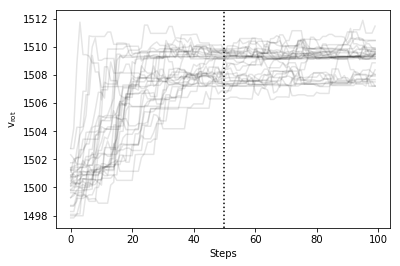

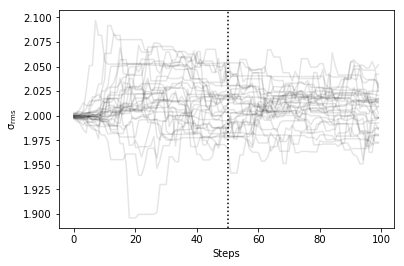

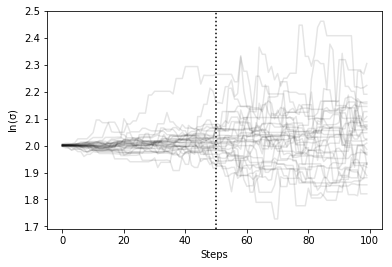

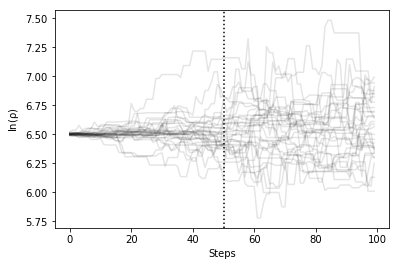

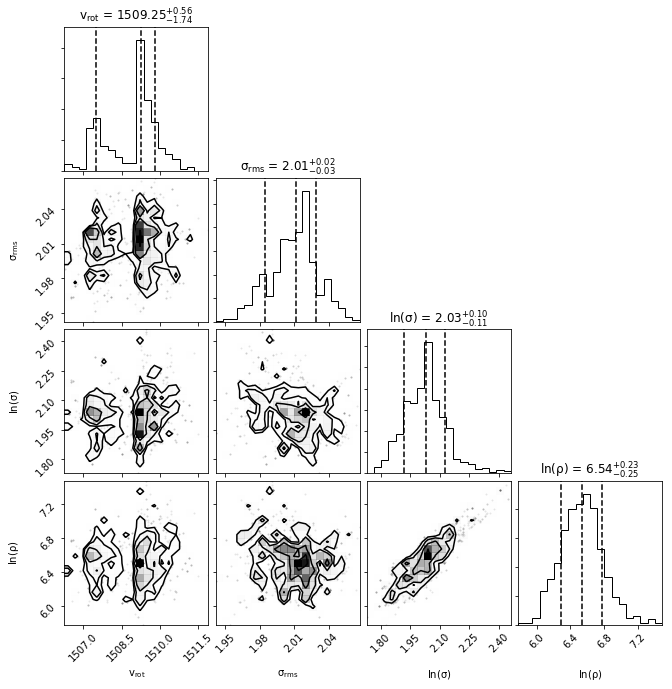

In [5]:
vfit = ensemble.get_vlos(p0=[1500., 2.0, 2.0, 6.5], fit_method='GP', nwalkers=32, nburnin=50,
                         nsteps=50, optimize=False, returns=['percentiles'])

print(vfit)
print("Best fit rotation velocity was %.1f +\- %.1f m/s." % (vfit[1], 0.5 * (vfit[2] - vfit[0])))

We can also make the lines non-Gaussian by assuming a large optical depth. This means the line cores will saturate and result in a flat-topped profile. These make it very hard to fit an accurate linewidth and thus the previous method would struggle. We assume an optically thick line takes the form $T_{\rm B} = T_{\rm ex} \big(1 - \exp(-\tau)\big)$ where $\tau$ is a Gaussian profile.

Best fit rotation velocity was 1500.6 +\- 2.7 m/s.


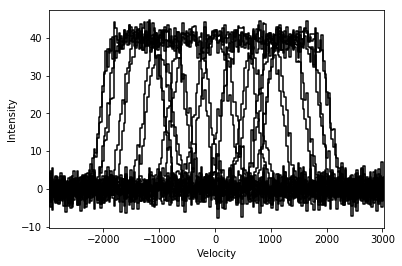

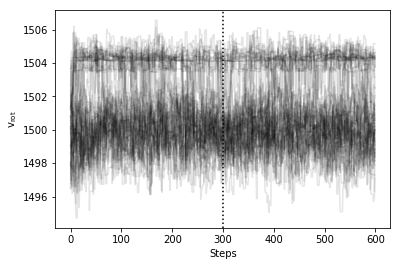

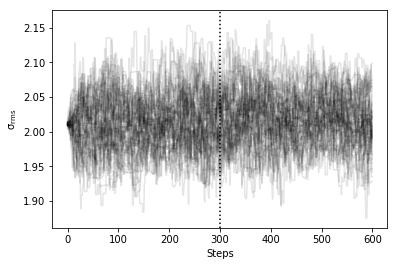

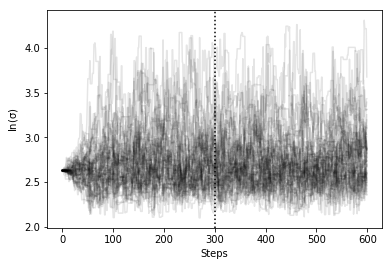

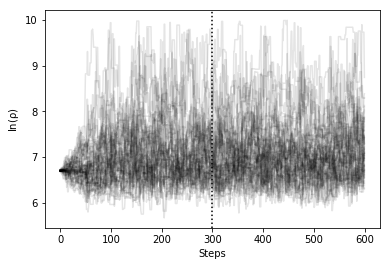

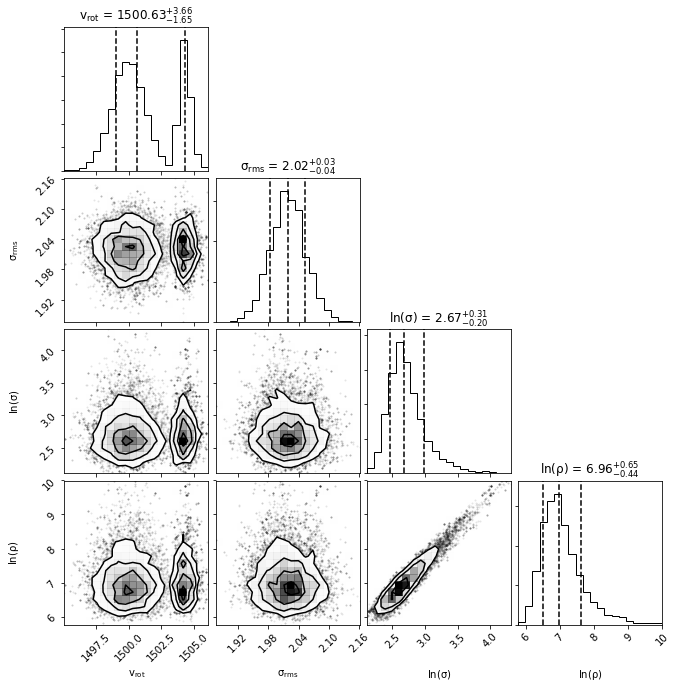

In [4]:
annulus = gaussian_ensemble(vrot=1500., Tb=40., dV=350., rms=2.0, N=20, tau=10.0, plot=True, return_ensemble=True)
vfit = annulus.get_vrot_GP(plot_walkers=True, plot_corner=True)
print("Best fit rotation velocity was %.1f +\- %.1f m/s." % (vfit[1], 0.5 * (vfit[2] - vfit[0])))

Note that with such a flat topped spectrum, it is much harder to define the correct alignment and so sometimes there is a secondary (or tertiary, depending on the signal-to-noise of the data) minimum. However, by using the percentiles of the posterior distribution this can usually be accounted for.

To get a more thorough smapling of the posterior we can of course increase the number of walkers and their initial scatter around their estimated values. Obviously thiss takes a little more time...

Best fit rotation velocity was 1500.8 +\- 2.6 m/s.


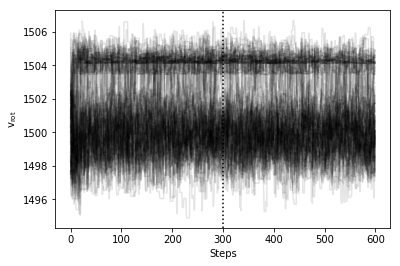

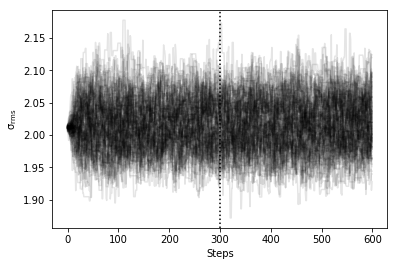

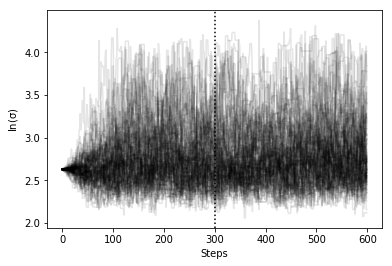

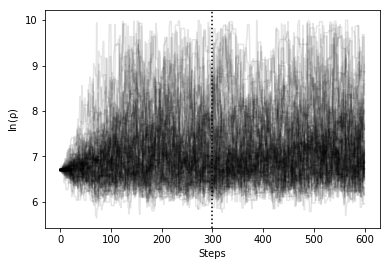

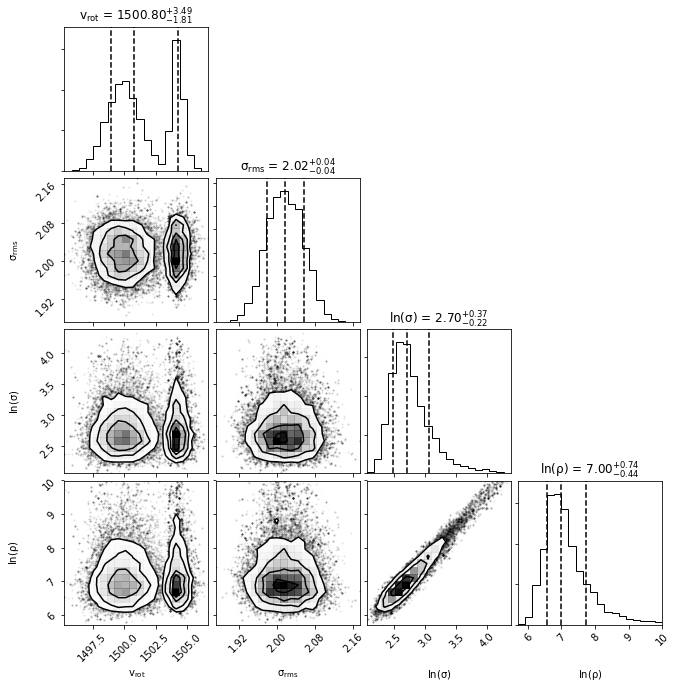

In [6]:
vfit = annulus.get_vrot_GP(nwalkers=128, plot_walkers=True, plot_corner=True)
print("Best fit rotation velocity was %.1f +\- %.1f m/s." % (vfit[1], 0.5 * (vfit[2] - vfit[0])))

As a final test we can compare how well this method does with low signal-to-noise data (SNR = 4).

Best fit rotation velocity was 1496.0 +\- 6.8 m/s.


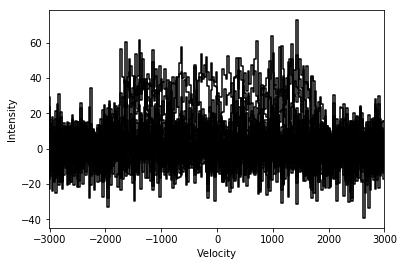

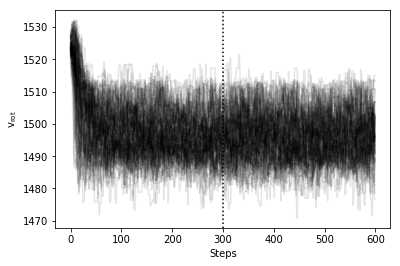

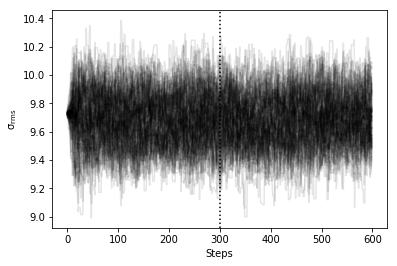

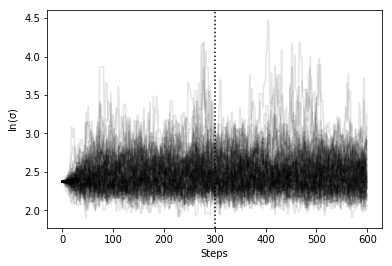

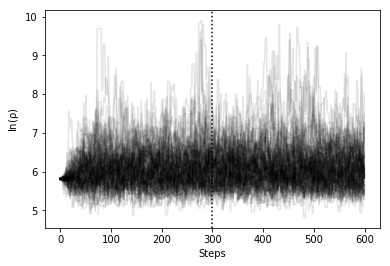

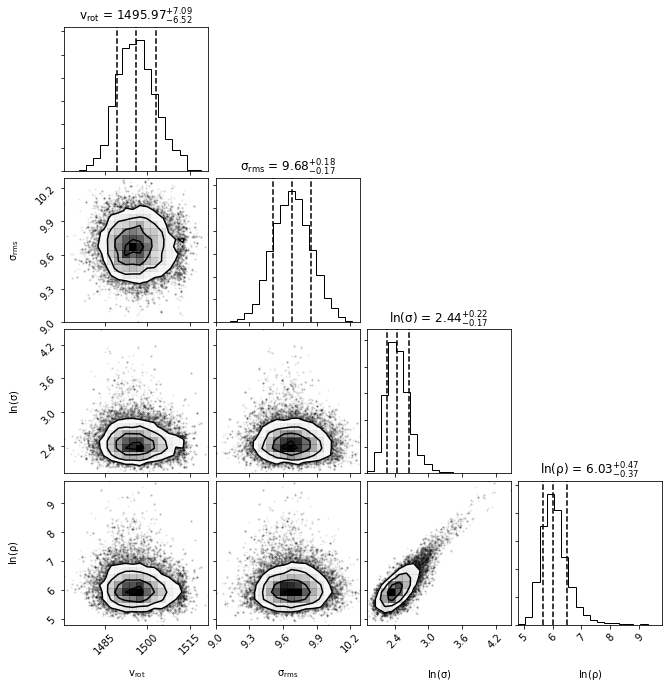

In [7]:
annulus = gaussian_ensemble(vrot=1500., Tb=40., dV=350., rms=10.0, N=20, plot=True, return_ensemble=True)
vfit = annulus.get_vrot_GP(nwalkers=128, plot_walkers=True, plot_corner=True)
print("Best fit rotation velocity was %.1f +\- %.1f m/s." % (vfit[1], 0.5 * (vfit[2] - vfit[0])))

## Extracting Annuli From Real Data

In the above examples we used model data to demonstrate how to measure the rotation velocity, but we didn't discuss how to get this data from your observations. We need a `spectra` array which has shape `(N, M)` where `N` is the number of spectra and `M` is the length of the velocity axis. We also need `theta`, which is a 1D, `N` length array of the polar angles of the specta. Finally we need `velax`, a length `M` 1D array of the velocity values. There are multiple ways to achieve this, however you can get the necessary values using the functions in the `rotationmap` class using a 3D cube rather than the 2D cubes it was designed to take. 

### Using `rotationmap` to Extract Spectra

First, constrain the geometry of the source in order to define an annulus. This include the source inclination and position angle on the sky. For more spatially resolved sources this may also include a flared emission surface. A quick way to do this is with `rotationmap.fit_keplerian` in `fit_cube`. See the "Fitting Rotation Maps" notebook for more information on how to do this. **Note:** For this you need to use a 2D moment map rather than the full 3D cube we use in the following steps.

Secondly, use these parmameters, (`x0`, `y0`, `inc`, `PA`), to mask a region within some bounding radii. This again can be easily achieved with the `rotationmap` class and the `disk_coords` function after initializing the class with the 3D cube from which you wish to extract spectra:

```python
    # Load the cube and find the pixel coordinates.
    from eddy.fit_cube import rotationmap
    cube = rotationmap('path/to/cube.fits')
    rvals, tvals, _ = cube.disk_coords(x0=x0, y0=y0, inc=inc, PA=PA)
```

which will return the deprojected radial values, `rvals` and polar angles, `tvals`, for each pixel. As discussed in the "Fitting Rotation Maps" notebook, we can also consider a flared emission surface described with the `z0` and `psi` parameters which `disk_coords` also accepts, along with a `tilt` value which describe the rotation of the disk.

A simple 2D mask can then be made with Numpy,

```python
    # Generate the mask.
    mask = np.logical_and(rvals >= r_min, rvals <= r_max)
    mask = mask.flatten()
```

where `r_min` and `r_max` are the inner and outer radii of the annulus in arcseconds. and which can be applied to the `cube.data` and `tvals` arrays, such as:

```python
    # Apply the mask to the data.
    spectra = cube.data.reshape(cube.data.shape[0], -1)
    spectra = spectra.flatten()[:, mask].T
    theta = tvals.flatten()[mask]
```

For the velocity axis, this isn't something that `rotationmap` does automatically as it works with just 2D images (moment maps). However you can extract it using something like:

```python
    # Get the velocity axis (assuming it is the third axis).
    velax = np.arange(cube.header['naxis3']) - cube.header['crpix3'] + 1.0
    velax = cube.header['crval3'] + velax * cube.header['cdelt3']
```

Remember to make sure this is velocity, as sometimes the spectral axis is given in frequency. This again is a simple coversion,

```python
    # Convert frequency to velocity.
    nu = cube.header['restfreq']
    velax = 2.9979e8 * (nu - velax) / nu
```

These can then be used to generate an `annulus` instance.

In [13]:
returns = 'perCENTilEs'
returns = [r.lower() for r in np.atleast_1d(returns)]

print(returns.index('test'))

ValueError: 'test' is not in list